In [1]:
# General
import xarray as xr    # handles netcdf data
import numpy as np     # numerical functions etc
import pandas as pd    # dataframes
import matplotlib      # plotting functions
import matplotlib.pyplot as plt    # specific plotting function I use a lot   
from matplotlib.patches import Rectangle     # specific plotting function with an annoyingly long name
import matplotlib.gridspec as gridspec #to define the sizes of plots specifically
import geopandas as gpd    # shapefiles
import cartopy     # plotting geographical features
from shapely.geometry import MultiPolygon, Polygon #to deal with 3D polygons
import regionmask    # convert shapefile to binary 0,1 mask
import re     # regular expressions (replace substrings etc)
from geopy.geocoders import Nominatim    # get lat & lon coordinates from a place name

#for climate indices
import xclim.indices as xc_i
import xclim as xc

#For plotting
import matplotlib.ticker as plticker
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import nc_time_axis #to plot cf.time axis
import cftime #to plot cf.time axis

#For Statistics
import scipy.stats as stats
from scipy import optimize
from xclim.indices.stats import fit
from scipy.stats import norm, gamma
import lmoments3.distr                     # conda activate xclim; pip install git+https://github.com/OpenHydrology/lmoments3.git
glo = getattr(lmoments3.distr, "glo")

#For copulas
import sklarpy.univariate as sk_uni
from sklarpy.copulas import gh_copula
from sklarpy.multivariate import mvt_normal
from sklarpy.copulas import MarginalFitter
from sklarpy.univariate import UnivariateFitter
from sklarpy import print_full
from sklarpy.copulas import gumbel_copula
from sklarpy.copulas import frank_copula
from sklarpy.copulas import clayton_copula

#For handling errors
import sys
import warnings

## Necessary Functions:

In [2]:
def get_SPEI_Duration_and_Severity_RunTheory(spei,threshold_drought=-0.8,threshold_minor=-1.5,threshold_combining=1):
    '''
    Summary:
    -----------
    Function which calculates the Severity-Duration pairs for a given SPEI timeseries. 
    
    Parameters:
    -----------
    spei: xarray DataArray oject
            - Timeseries containing the spei values
            
    threshold_drought: float 
            - Threshold representing the onset of a drought event
         
    threshold_minor: float 
            - Threshold representing the minium spei value for a 1-month event to be considered a drought
    
    threshold_combining: float 
            - Threshold representing the minium spei value which needs to be exceeded that two drought events which
            are separated by only one month to be considered individual events
         
    Returns:
    ----------
    Duration: Array
            - Values representing the Duration of the Drought events      
        
    Severity: Array
            - Values representing the Severity of the Drought events   
    '''
    
    #Set-up Array
    duration=[]
    severity=[]
    
    D=0
    S=0
    for t in np.arange(0,len(spei),1):
        #Drought Condition
        if spei[t]<threshold_drought:
            D=D+1
            S=S+spei[t]
            
        #To take the case into account if last value is just one month -> ongoing heatwave, 
        #only when last severity is lower than threshold_combining and severity of event larger than threshold_minor!
        elif spei[t-1]<threshold_drought and t==len(spei)-1 and spei[t]<threshold_combining and spei[t] < threshold_minor:
            D=D+1
            S=S
            
        #The condition before corrected for the last loop
        elif t!=len(spei)-1 and spei[t-1]<threshold_drought and spei[t+1]<threshold_drought and spei[t]<threshold_combining:
            D=D+1
            S=S
        
        #If the spei value is above the threshold and none of the conditions above apply that drought event is over
        else:
            duration.append(D )
            D=0
            severity.append(S)
            S=0

    #to get values if the drought ends in the loop
    duration.append(D)
    severity.append(S)
    
    #remove all durations of 1 if Severity is less than threshold (here set to: -1.5) 
    for i in np.arange(0,len(duration),1):
        if duration[i] == 1:
            if severity[i] > threshold_minor:
                duration[i] = 0
                severity[i] = 0
                
    #Remove all 0 and define severity positive
    duration = np.array(duration)
    duration = duration[duration>0]
    
    severity = np.array(severity)
    severity = -severity
    severity = severity[severity>0]      
    
    return duration, severity

# Get CMIP6 Data

In [3]:
dir_data = '/rds/general/user/nmerz/home/MSc_Diss/data/AR6_regions/CMIP6/'

### Load Regions

In [4]:
sf_all = gpd.read_file("/rds/general/user/nmerz/home/MSc_Diss/data/AR6_regions/shapefile").to_crs(cartopy.crs.PlateCarree())
sf_SA = sf_all[sf_all['Acronym'].str.contains("NWS|NSA|NES|SAM|SWS|SES|SSA")]

fn_tmin = '/rds/general/user/nmerz/home/MSc_Diss/data/AR6_regions/obs/era5/model_data/era5_tmin_daily_275-330E_15--60N_su.nc'
ds_tmin = xr.open_dataset(fn_tmin).sel(time=slice("1950","2023"))
era5_tmin = ds_tmin.tmin

rm_SA = regionmask.mask_3D_geopandas(sf_SA, era5_tmin.lon, era5_tmin.lat).squeeze(drop = True)
sf_9 = sf_all[sf_all['Acronym'].str.contains("NWS")]
rm_9 = regionmask.mask_3D_geopandas(sf_9, era5_tmin.lon, era5_tmin.lat).squeeze(drop = True)
sf_10 = sf_all[sf_all['Acronym'].str.contains("NSA")]
rm_10 = regionmask.mask_3D_geopandas(sf_10, era5_tmin.lon, era5_tmin.lat).squeeze(drop = True)
sf_11 = sf_all[sf_all['Acronym'].str.contains("NES")]
rm_11 = regionmask.mask_3D_geopandas(sf_11, era5_tmin.lon, era5_tmin.lat).squeeze(drop = True)
sf_12 = sf_all[sf_all['Acronym'].str.contains("SAM")]
rm_12 = regionmask.mask_3D_geopandas(sf_12, era5_tmin.lon, era5_tmin.lat).squeeze(drop = True)
sf_13 = sf_all[sf_all['Acronym'].str.contains("SWS")]
rm_13 = regionmask.mask_3D_geopandas(sf_13, era5_tmin.lon, era5_tmin.lat).squeeze(drop = True)
sf_14 = sf_all[sf_all['Acronym'].str.contains("SES")]
rm_14 = regionmask.mask_3D_geopandas(sf_14, era5_tmin.lon, era5_tmin.lat).squeeze(drop = True)
sf_15 = sf_all[sf_all['Acronym'].str.contains("SSA")]
rm_15 = regionmask.mask_3D_geopandas(sf_15, era5_tmin.lon, era5_tmin.lat).squeeze(drop = True)

sf_shp_arr = np.array([sf_9,sf_10,sf_11,sf_12,sf_13,sf_14,sf_15])
region_shp_arr = np.array([rm_9,rm_10,rm_11,rm_12,rm_13,rm_14,rm_15])

## Load data


In [5]:
#Define the return period for the Drought Atlas
return_T = 50
T_str = str(return_T)

In [6]:
model_M1_arr = np.zeros((8))
model_M1 = model_M1_arr.tolist()

#define the Aggregation period (1, 6, 12)
M_spei = 1
M_spei_str = str(M_spei)

#define the duration for the DA plot
M1_D = 3
M1_D_str = str(M1_D)

#ACCESS-CM2 #AccessCm2 
model_name = "ACCESS-CM2/"
fn_DA_AccessCm2 = dir_data + model_name + "results_sev_given_T_D/df_sev_M" + M_spei_str + "_T" + T_str + "_D" + M1_D_str + "_final.csv"
model_M1[0] = pd.read_csv(fn_DA_AccessCm2,sep=";",usecols=[1,2,3,4,5])

#ACCESS-ESM1-5 #AccessEsm15 
model_name = "ACCESS-ESM1-5/"
fn_DA_AccessEsm15 = dir_data + model_name + "results_sev_given_T_D/df_sev_M" + M_spei_str + "_T" + T_str + "_D" + M1_D_str + "_final.csv"
model_M1[1] = pd.read_csv(fn_DA_AccessEsm15,sep=";",usecols=[1,2,3,4,5])

#CanESM5 #CanEsm5
model_name = "CanESM5/"
fn_DA_CanEsm5 = dir_data + model_name + "results_sev_given_T_D/df_sev_M" + M_spei_str + "_T" + T_str + "_D" + M1_D_str + "_final.csv"
model_M1[2] = pd.read_csv(fn_DA_CanEsm5,sep=";",usecols=[1,2,3,4,5])

#FGOALS-g3 #FgoalsG3
model_name = "FGOALS-g3/"
fn_DA_FgoalsG3 = dir_data + model_name + "results_sev_given_T_D/df_sev_M" + M_spei_str + "_T" + T_str + "_D" + M1_D_str + "_final.csv"
model_M1[3] = pd.read_csv(fn_DA_FgoalsG3,sep=";",usecols=[1,2,3,4,5])

#IPSL-CM6A-LR #IpslCm6aLr
model_name = "IPSL-CM6A-LR/"
fn_DA_IpslCm6aLr = dir_data + model_name + "results_sev_given_T_D/df_sev_M" + M_spei_str + "_T" + T_str + "_D" + M1_D_str + "_final.csv"
model_M1[4] = pd.read_csv(fn_DA_IpslCm6aLr,sep=";",usecols=[1,2,3,4,5])

#MIROC6 #Miroc6
model_name = "MIROC6/"
fn_DA_Miroc6 = dir_data + model_name + "results_sev_given_T_D/df_sev_M" + M_spei_str + "_T" + T_str + "_D" + M1_D_str + "_final.csv"
model_M1[5] = pd.read_csv(fn_DA_Miroc6,sep=";",usecols=[1,2,3,4,5])

#MRI-ESM2-0 #MriEsm20
model_name = "MRI-ESM2-0/"
fn_DA_MriEsm20 = dir_data + model_name + "results_sev_given_T_D/df_sev_M" + M_spei_str + "_T" + T_str + "_D" + M1_D_str + "_final.csv"
model_M1[6] = pd.read_csv(fn_DA_MriEsm20,sep=";",usecols=[1,2,3,4,5])

#NorESM2-LM #NorEsm2Lm
model_name = "NorESM2-LM/"
fn_DA_NorEsm2Lm = dir_data + model_name + "results_sev_given_T_D/df_sev_M" + M_spei_str + "_T" + T_str + "_D" + M1_D_str + "_final.csv"
model_M1[7] = pd.read_csv(fn_DA_NorEsm2Lm,sep=";",usecols=[1,2,3,4,5])

In [7]:
model_M6_arr = np.zeros((8))
model_M6 = model_M6_arr.tolist()

#define the Aggregation period (1, 6, 12)
M_spei = 6
M_spei_str = str(M_spei)

#define the duration for the DA plot
M6_D = 6
M6_D_str = str(M6_D)

#ACCESS-CM2 #AccessCm2 
model_name = "ACCESS-CM2/"
fn_DA_AccessCm2 = dir_data + model_name + "results_sev_given_T_D/df_sev_M" + M_spei_str + "_T" + T_str + "_D" + M6_D_str + "_final.csv"
model_M6[0] = pd.read_csv(fn_DA_AccessCm2,sep=";",usecols=[1,2,3,4,5])

#ACCESS-ESM1-5 #AccessEsm15 
model_name = "ACCESS-ESM1-5/"
fn_DA_AccessEsm15 = dir_data + model_name + "results_sev_given_T_D/df_sev_M" + M_spei_str + "_T" + T_str + "_D" + M6_D_str + "_final.csv"
model_M6[1] = pd.read_csv(fn_DA_AccessEsm15,sep=";",usecols=[1,2,3,4,5])

#CanESM5 #CanEsm5
model_name = "CanESM5/"
fn_DA_CanEsm5 = dir_data + model_name + "results_sev_given_T_D/df_sev_M" + M_spei_str + "_T" + T_str + "_D" + M6_D_str + "_final.csv"
model_M6[2] = pd.read_csv(fn_DA_CanEsm5,sep=";",usecols=[1,2,3,4,5])

#FGOALS-g3 #FgoalsG3
model_name = "FGOALS-g3/"
fn_DA_FgoalsG3 = dir_data + model_name + "results_sev_given_T_D/df_sev_M" + M_spei_str + "_T" + T_str + "_D" + M6_D_str + "_final.csv"
model_M6[3] = pd.read_csv(fn_DA_FgoalsG3,sep=";",usecols=[1,2,3,4,5])

#IPSL-CM6A-LR #IpslCm6aLr
model_name = "IPSL-CM6A-LR/"
fn_DA_IpslCm6aLr = dir_data + model_name + "results_sev_given_T_D/df_sev_M" + M_spei_str + "_T" + T_str + "_D" + M6_D_str + "_final.csv"
model_M6[4] = pd.read_csv(fn_DA_IpslCm6aLr,sep=";",usecols=[1,2,3,4,5])

#MIROC6 #Miroc6
model_name = "MIROC6/"
fn_DA_Miroc6 = dir_data + model_name + "results_sev_given_T_D/df_sev_M" + M_spei_str + "_T" + T_str + "_D" + M6_D_str + "_final.csv"
model_M6[5] = pd.read_csv(fn_DA_Miroc6,sep=";",usecols=[1,2,3,4,5])

#MRI-ESM2-0 #MriEsm20
model_name = "MRI-ESM2-0/"
fn_DA_MriEsm20 = dir_data + model_name + "results_sev_given_T_D/df_sev_M" + M_spei_str + "_T" + T_str + "_D" + M6_D_str + "_final.csv"
model_M6[6] = pd.read_csv(fn_DA_MriEsm20,sep=";",usecols=[1,2,3,4,5])

#NorESM2-LM #NorEsm2Lm
model_name = "NorESM2-LM/"
fn_DA_NorEsm2Lm = dir_data + model_name + "results_sev_given_T_D/df_sev_M" + M_spei_str + "_T" + T_str + "_D" + M6_D_str + "_final.csv"
model_M6[7] = pd.read_csv(fn_DA_NorEsm2Lm,sep=";",usecols=[1,2,3,4,5])

In [8]:
model_M12_arr = np.zeros((8))
model_M12 = model_M12_arr.tolist()

#define the Aggregation period (1, 6, 12)
M_spei = 12
M_spei_str = str(M_spei)

#define the duration for the DA plot
M12_D = 12
M12_D_str = str(M12_D)

#ACCESS-CM2 #AccessCm2 
model_name = "ACCESS-CM2/"
fn_DA_AccessCm2 = dir_data + model_name + "results_sev_given_T_D/df_sev_M" + M_spei_str + "_T" + T_str + "_D" + M12_D_str + "_final.csv"
model_M12[0] = pd.read_csv(fn_DA_AccessCm2,sep=";",usecols=[1,2,3,4,5])

#ACCESS-ESM1-5 #AccessEsm15 
model_name = "ACCESS-ESM1-5/"
fn_DA_AccessEsm15 = dir_data + model_name + "results_sev_given_T_D/df_sev_M" + M_spei_str + "_T" + T_str + "_D" + M12_D_str + "_final.csv"
model_M12[1] = pd.read_csv(fn_DA_AccessEsm15,sep=";",usecols=[1,2,3,4,5])

#CanESM5 #CanEsm5
model_name = "CanESM5/"
fn_DA_CanEsm5 = dir_data + model_name + "results_sev_given_T_D/df_sev_M" + M_spei_str + "_T" + T_str + "_D" + M12_D_str + "_final.csv"
model_M12[2] = pd.read_csv(fn_DA_CanEsm5,sep=";",usecols=[1,2,3,4,5])

#FGOALS-g3 #FgoalsG3
model_name = "FGOALS-g3/"
fn_DA_FgoalsG3 = dir_data + model_name + "results_sev_given_T_D/df_sev_M" + M_spei_str + "_T" + T_str + "_D" + M12_D_str + "_final.csv"
model_M12[3] = pd.read_csv(fn_DA_FgoalsG3,sep=";",usecols=[1,2,3,4,5])

#IPSL-CM6A-LR #IpslCm6aLr
model_name = "IPSL-CM6A-LR/"
fn_DA_IpslCm6aLr = dir_data + model_name + "results_sev_given_T_D/df_sev_M" + M_spei_str + "_T" + T_str + "_D" + M12_D_str + "_final.csv"
model_M12[4] = pd.read_csv(fn_DA_IpslCm6aLr,sep=";",usecols=[1,2,3,4,5])

#MIROC6 #Miroc6
model_name = "MIROC6/"
fn_DA_Miroc6 = dir_data + model_name + "results_sev_given_T_D/df_sev_M" + M_spei_str + "_T" + T_str + "_D" + M12_D_str + "_final.csv"
model_M12[5] = pd.read_csv(fn_DA_Miroc6,sep=";",usecols=[1,2,3,4,5])

#MRI-ESM2-0 #MriEsm20
model_name = "MRI-ESM2-0/"
fn_DA_MriEsm20 = dir_data + model_name + "results_sev_given_T_D/df_sev_M" + M_spei_str + "_T" + T_str + "_D" + M12_D_str + "_final.csv"
model_M12[6] = pd.read_csv(fn_DA_MriEsm20,sep=";",usecols=[1,2,3,4,5])

#NorESM2-LM #NorEsm2Lm
model_name = "NorESM2-LM/"
fn_DA_NorEsm2Lm = dir_data + model_name + "results_sev_given_T_D/df_sev_M" + M_spei_str + "_T" + T_str + "_D" + M12_D_str + "_final.csv"
model_M12[7] = pd.read_csv(fn_DA_NorEsm2Lm,sep=";",usecols=[1,2,3,4,5])

In [9]:
names_models = ['9_NWS','10_NSA','11_NES','12_SAM','13_SWS','14_SES','15_SSA',None]

## Plot the Drought Atlas

### Set up the result files

In [11]:
#Set-up Result Files
fn_lon_lat ='/rds/general/user/nmerz/home/MSc_Diss/data/AR6_regions/obs/era5/nSPEI_HG85_cal1980_2010/spei_M1_9.nc'
lon_lat_raw = xr.open_dataset(fn_lon_lat)

rm = regionmask.mask_3D_geopandas(sf_9, era5_tmin.lon, era5_tmin.lat).squeeze(drop = True)

sev_DA_nc_histnat_3 = lon_lat_raw
sev_DA_nc_histnat_2 = sev_DA_nc_histnat_3.assign(sev_T100_d1=np.nan)
sev_DA_nc_histnat_1 = sev_DA_nc_histnat_2.drop_vars("spei").mean(dim="time")
sev_DA_nc_histnat_M1 = sev_DA_nc_histnat_1.where(~rm)
sev_DA_nc_histnat_M6 = sev_DA_nc_histnat_1.where(~rm)
sev_DA_nc_histnat_M12 = sev_DA_nc_histnat_1.where(~rm)

sev_DA_nc_historic_3 = lon_lat_raw
sev_DA_nc_historic_2 = sev_DA_nc_historic_3.assign(sev_T100_d1=np.nan)
sev_DA_nc_historic_1 = sev_DA_nc_historic_2.drop_vars("spei").mean(dim="time")
sev_DA_nc_historic_M1 = sev_DA_nc_historic_1.where(~rm)
sev_DA_nc_historic_M6 = sev_DA_nc_historic_1.where(~rm)
sev_DA_nc_historic_M12 = sev_DA_nc_historic_1.where(~rm)

sev_DA_nc_ssp245_3 = lon_lat_raw
sev_DA_nc_ssp245_2 = sev_DA_nc_ssp245_3.assign(sev_T100_d1=np.nan)
sev_DA_nc_ssp245_1 = sev_DA_nc_ssp245_2.drop_vars("spei").mean(dim="time")
sev_DA_nc_ssp245_M1 = sev_DA_nc_ssp245_1.where(~rm)
sev_DA_nc_ssp245_M6 = sev_DA_nc_ssp245_1.where(~rm)
sev_DA_nc_ssp245_M12 = sev_DA_nc_ssp245_1.where(~rm)

sev_DA_nc_ssp585_3 = lon_lat_raw
sev_DA_nc_ssp585_2 = sev_DA_nc_ssp585_3.assign(sev_T100_d1=np.nan)
sev_DA_nc_ssp585_1 = sev_DA_nc_ssp585_2.drop_vars("spei").mean(dim="time")
sev_DA_nc_ssp585_M1 = sev_DA_nc_ssp585_1.where(~rm)
sev_DA_nc_ssp585_M6 = sev_DA_nc_ssp585_1.where(~rm)
sev_DA_nc_ssp585_M12 = sev_DA_nc_ssp585_1.where(~rm)

### M1

In [12]:
#Based on the Model Evaluation
M1_region_9_models=[None,None,2,3,4,5,6,7]
M1_region_10_models=[None,1,2,None,4,5,6,7]
M1_region_11_models=[0,1,None,None,None,5,6,7]
M1_region_12_models=[0,1,2,3,4,5,6,None]
M1_region_13_models=[0,1,2,3,4,5,6,7]
M1_region_14_models=[None,None,2,3,None,5,6,7]
M1_region_15_models=[0,1,2,3,4,5,6,7]
M1_region_models=[M1_region_9_models,M1_region_10_models,M1_region_11_models,M1_region_12_models,M1_region_13_models,M1_region_14_models,M1_region_15_models]

In [13]:
M1_res_histnat_arr = []
M1_res_historic_arr = []
M1_res_ssp245_arr = []
M1_res_ssp585_arr = []
for s in np.arange(0,7,1):    
    region_eval = M1_region_models[s]
    #print(region_eval)
    M1_val_histnat_arr = []
    M1_val_historic_arr = []
    M1_val_ssp245_arr = []
    M1_val_ssp585_arr = []
    
    fn_return_T = "sev_M1_T" + T_str
    for m in np.arange(0,8):
        if region_eval[m] is not None:
            M1_fn_histnat = fn_return_T + "_D" + M1_D_str + "_histnat"
            M1_val_histnat_arr.append(model_M1[m][M1_fn_histnat][s])
            M1_fn_historic = fn_return_T + "_D" + M1_D_str + "_historic"
            M1_val_historic_arr.append(model_M1[m][M1_fn_historic][s])
            M1_fn_ssp245 = fn_return_T + "_D" + M1_D_str + "_ssp245"
            M1_val_ssp245_arr.append(model_M1[m][M1_fn_ssp245][s])
            M1_fn_ssp585 = fn_return_T + "_D" + M1_D_str + "_ssp585"
            M1_val_ssp585_arr.append(model_M1[m][M1_fn_ssp585][s])

    #print(len(M1_val_histnat_arr))
    M1_res_histnat_arr.append(np.array(M1_val_histnat_arr).mean())
    M1_res_historic_arr.append(np.array(M1_val_historic_arr).mean())
    M1_res_ssp245_arr.append(np.array(M1_val_ssp245_arr).mean())
    M1_res_ssp585_arr.append(np.array(M1_val_ssp585_arr).mean())

M1_data_sev_DA = {
    'Region': ['9_NWS','10_NSA','11_NES','12_SAM','13_SWS','14_SES','15_SSA'],
    M1_fn_histnat: M1_res_histnat_arr,
    M1_fn_historic: M1_res_historic_arr,
    M1_fn_ssp245: M1_res_ssp245_arr,
    M1_fn_ssp585: M1_res_ssp585_arr,
}
  
M1_df_sev_DA = pd.DataFrame(M1_data_sev_DA)
display(M1_df_sev_DA) 

,Region,sev_M1_T50_D3_histnat,sev_M1_T50_D3_historic,sev_M1_T50_D3_ssp245,sev_M1_T50_D3_ssp585
0,9_NWS,5.107394,5.198677,6.048038,6.805030
1,10_NSA,5.251856,5.813997,7.266583,8.318938
2,11_NES,6.281597,5.944972,8.231440,9.310642
3,12_SAM,5.162766,5.340354,8.367701,9.682253
4,13_SWS,4.614589,5.021685,7.635096,8.573632
5,14_SES,5.948879,5.480118,6.978848,7.630082
6,15_SSA,4.894990,4.921591,6.606742,7.712625


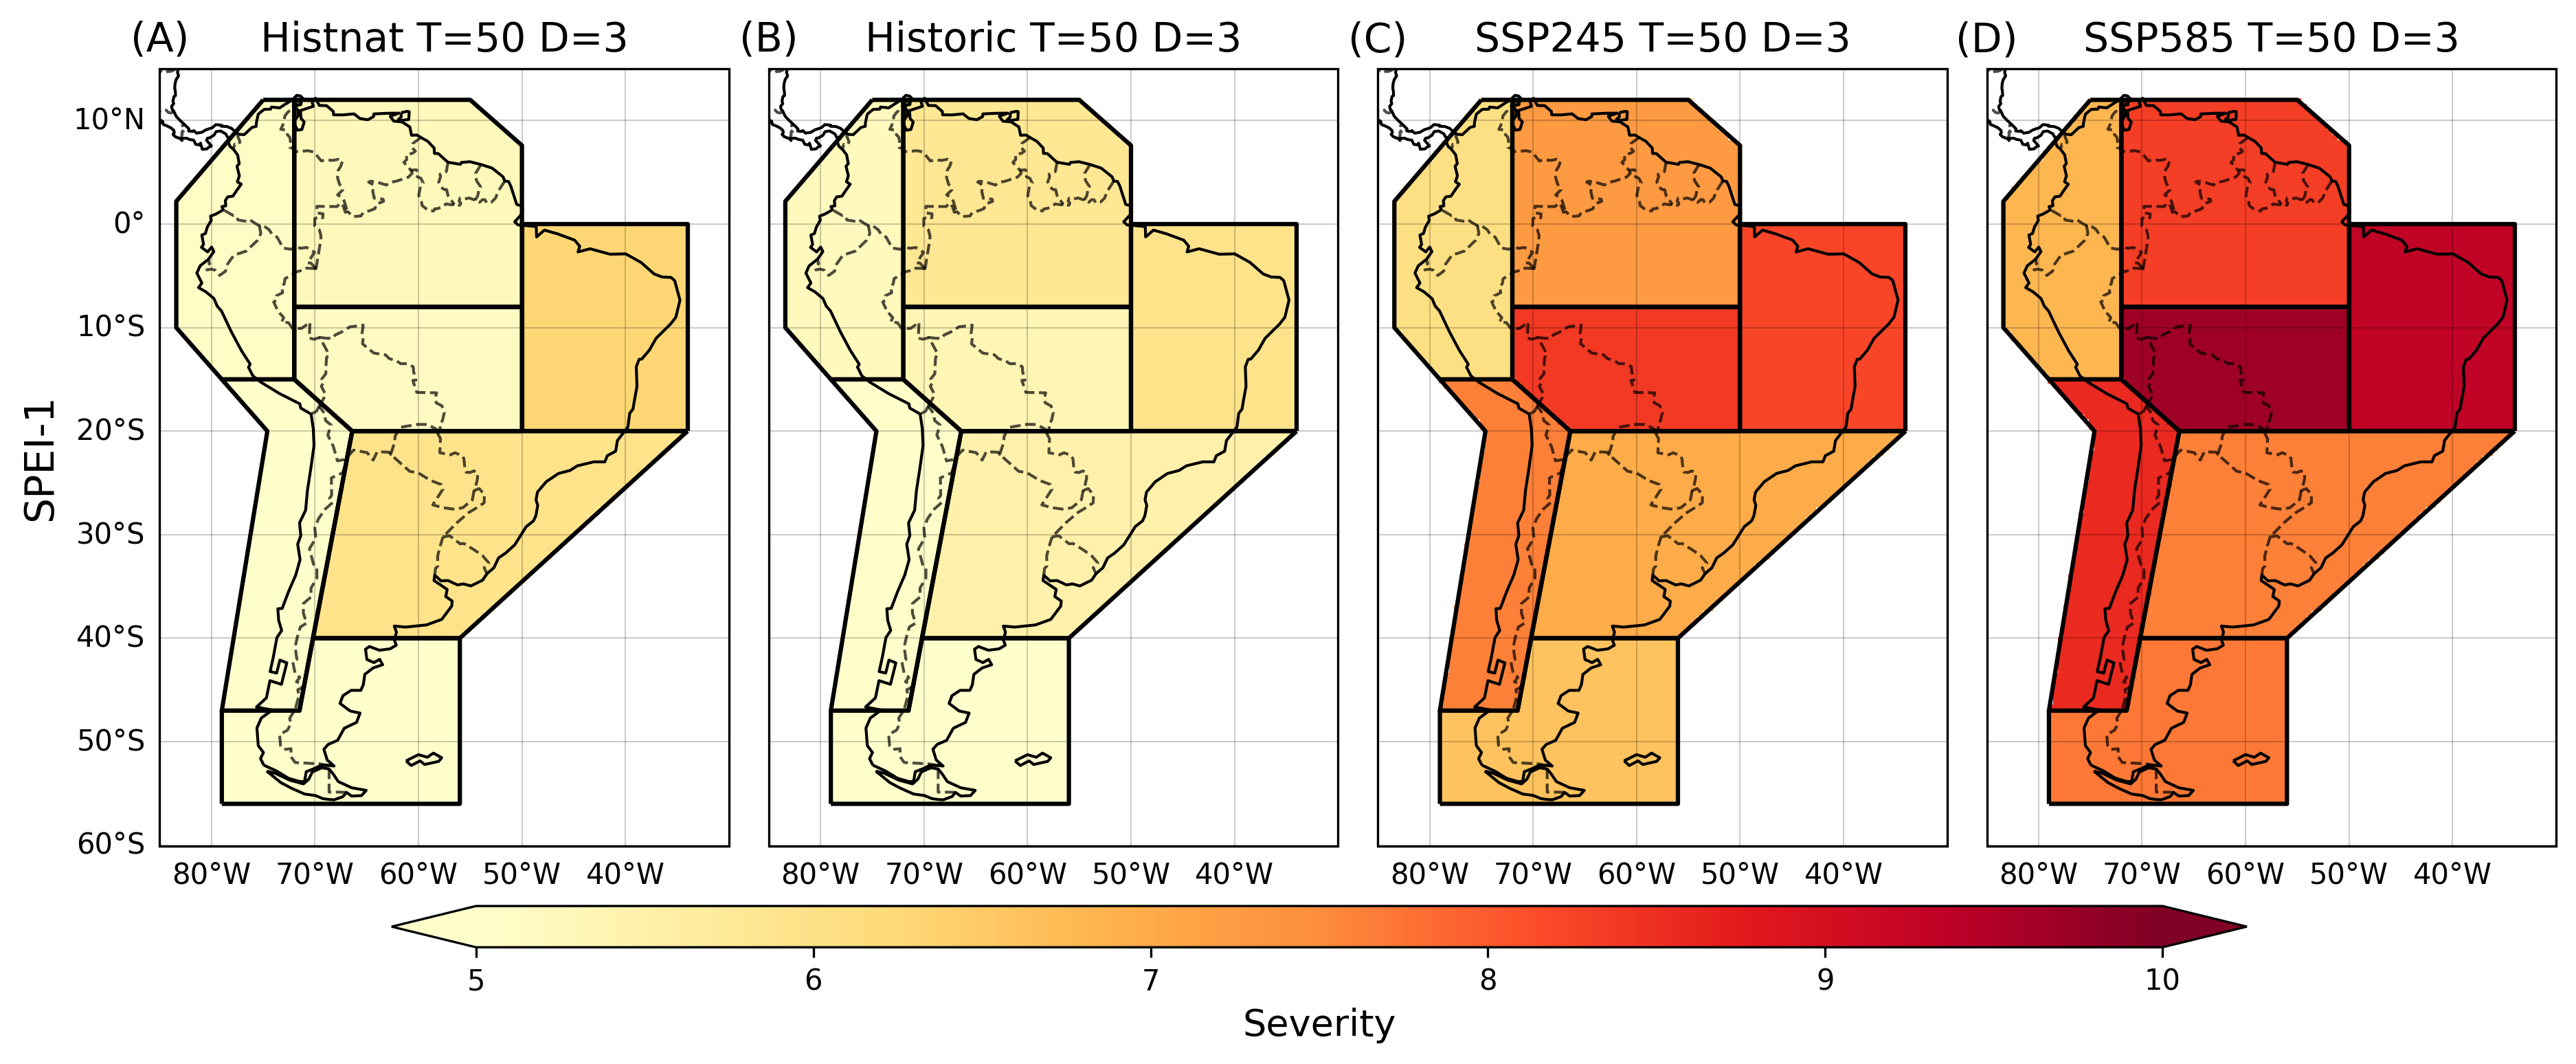

In [14]:
for s in np.arange(0,7):
    sev_DA_nc_histnat_M1 = sev_DA_nc_histnat_M1.where(~region_shp_arr[s], other=M1_df_sev_DA[M1_fn_histnat][s])
    sev_DA_nc_historic_M1 = sev_DA_nc_historic_M1.where(~region_shp_arr[s], other=M1_df_sev_DA[M1_fn_historic][s])
    sev_DA_nc_ssp245_M1 = sev_DA_nc_ssp245_M1.where(~region_shp_arr[s], other=M1_df_sev_DA[M1_fn_ssp245][s])
    sev_DA_nc_ssp585_M1 = sev_DA_nc_ssp585_M1.where(~region_shp_arr[s], other=M1_df_sev_DA[M1_fn_ssp585][s])

fig, ax = plt.subplots(ncols = 4, nrows = 1, figsize = (15,5),sharey="row", dpi = 300, subplot_kw = {"projection" : cartopy.crs.PlateCarree()})
fig.subplots_adjust(wspace=0.07)
elev_kwargs = {"cmap" : "YlOrRd",
               "vmin" : 5, 
               "vmax" : 10}    
cbar=sev_DA_nc_histnat_M1.sev_T100_d1.plot(ax = ax[0], **elev_kwargs, add_colorbar=False)
sev_DA_nc_historic_M1.sev_T100_d1.plot(ax = ax[1], **elev_kwargs, add_colorbar=False)
sev_DA_nc_ssp245_M1.sev_T100_d1.plot(ax = ax[2], **elev_kwargs, add_colorbar=False)
sev_DA_nc_ssp585_M1.sev_T100_d1.plot(ax = ax[3], **elev_kwargs, add_colorbar=False)

fn_names_histnat = "Histnat T=" + T_str + " D=" + M1_D_str
fn_names_historic = "Historic T=" + T_str + " D=" + M1_D_str
fn_names_ssp245 = "SSP245 T=" + T_str + " D=" + M1_D_str
fn_names_ssp585 = "SSP585 T=" + T_str + " D=" + M1_D_str
names = np.array([fn_names_histnat,fn_names_historic,fn_names_ssp245,fn_names_ssp585])

for i in np.arange(0,4):
    ax[i].coastlines()
    ax[i].add_feature(cartopy.feature.BORDERS, lw = 1, alpha = 0.7, ls = "--", zorder = 99)
    ax[i].set_title(names[i], loc = "center",fontsize=14)
    ax[i].set_xlim([-85,-30])
    ax[i].set_ylim([-60.1,15])
    sf_SA.boundary.plot(ax = ax[i], lw = 1.5, color = "black")


    
glt_1 = ax[0].gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', alpha=0.2, draw_labels=True)
glt_1.top_labels = False
glt_1.right_labels = False
ax[0].text(-0.21, 0.5, 'SPEI-1', transform=ax[0].transAxes, fontsize=14, va='center', ha='center', rotation=90)
for j in np.arange(1,4):
    glt_2 = ax[j].gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', alpha=0.2, draw_labels=True)
    glt_2.top_labels = False
    glt_2.right_labels = False
    glt_2.left_labels = False


cbar_ax = fig.add_axes([0.2, 0.02, 0.6, 0.04])        
cbar = plt.colorbar(cbar, cax=cbar_ax, location = "bottom", fraction = 0.03, pad = 0.09, extend = "both")
cbar.set_label(label = "Severity",fontsize=13)

# Add subplot labels
labels = ['(A)', '(B)', '(C)', '(D)']
for i, axes in enumerate(ax.flat):
    axes.annotate(labels[i], xy=(0, 1.037), xycoords='axes fraction',
                  fontsize=14, ha='center', va='center')

### M6

In [15]:
#Based on the Model Evaluation
M6_region_9_models=[None,None,2,3,4,5,6,7]
M6_region_10_models=[None,1,2,None,4,5,6,7]
M6_region_11_models=[0,1,None,None,None,5,6,7]
M6_region_12_models=[0,1,2,3,4,5,6,None]
M6_region_13_models=[0,1,2,3,4,5,6,7]
M6_region_14_models=[None,None,2,3,None,5,6,7]
M6_region_15_models=[0,1,2,3,4,5,6,7]
M6_region_models=[M6_region_9_models,M6_region_10_models,M6_region_11_models,M6_region_12_models,M6_region_13_models,M6_region_14_models,M6_region_15_models]

In [16]:
M6_res_histnat_arr = []
M6_res_historic_arr = []
M6_res_ssp245_arr = []
M6_res_ssp585_arr = []
for s in np.arange(0,7,1):    
    region_eval = M6_region_models[s]
    #print(region_eval)
    M6_val_histnat_arr = []
    M6_val_historic_arr = []
    M6_val_ssp245_arr = []
    M6_val_ssp585_arr = []
    
    fn_return_T = "sev_M6_T" + T_str
    for m in np.arange(0,8):
        if region_eval[m] is not None:
            M6_fn_histnat = fn_return_T + "_D" + M6_D_str + "_histnat"
            M6_val_histnat_arr.append(model_M6[m][M6_fn_histnat][s])
            M6_fn_historic = fn_return_T + "_D" + M6_D_str + "_historic"
            M6_val_historic_arr.append(model_M6[m][M6_fn_historic][s])
            M6_fn_ssp245 = fn_return_T + "_D" + M6_D_str + "_ssp245"
            M6_val_ssp245_arr.append(model_M6[m][M6_fn_ssp245][s])
            M6_fn_ssp585 = fn_return_T + "_D" + M6_D_str + "_ssp585"
            M6_val_ssp585_arr.append(model_M6[m][M6_fn_ssp585][s])

    #print(len(M1_val_histnat_arr))
    M6_res_histnat_arr.append(np.array(M6_val_histnat_arr).mean())
    M6_res_historic_arr.append(np.array(M6_val_historic_arr).mean())
    M6_res_ssp245_arr.append(np.array(M6_val_ssp245_arr).mean())
    M6_res_ssp585_arr.append(np.array(M6_val_ssp585_arr).mean())

M6_data_sev_DA = {
    'Region': ['9_NWS','10_NSA','11_NES','12_SAM','13_SWS','14_SES','15_SSA'],
    M6_fn_histnat: M6_res_histnat_arr,
    M6_fn_historic: M6_res_historic_arr,
    M6_fn_ssp245: M6_res_ssp245_arr,
    M6_fn_ssp585: M6_res_ssp585_arr,
}
  
M6_df_sev_DA = pd.DataFrame(M6_data_sev_DA)
display(M6_df_sev_DA) 

,Region,sev_M6_T50_D6_histnat,sev_M6_T50_D6_historic,sev_M6_T50_D6_ssp245,sev_M6_T50_D6_ssp585
0,9_NWS,9.793886,10.017622,11.766528,12.707068
1,10_NSA,8.694244,9.357833,11.419632,12.038276
2,11_NES,10.543701,9.783424,13.009573,13.339906
3,12_SAM,9.560093,10.168391,14.466327,14.989313
4,13_SWS,9.787697,10.930761,16.107570,16.129976
5,14_SES,11.259663,10.734021,13.284041,13.878739
6,15_SSA,9.998585,10.400999,12.805980,15.226606


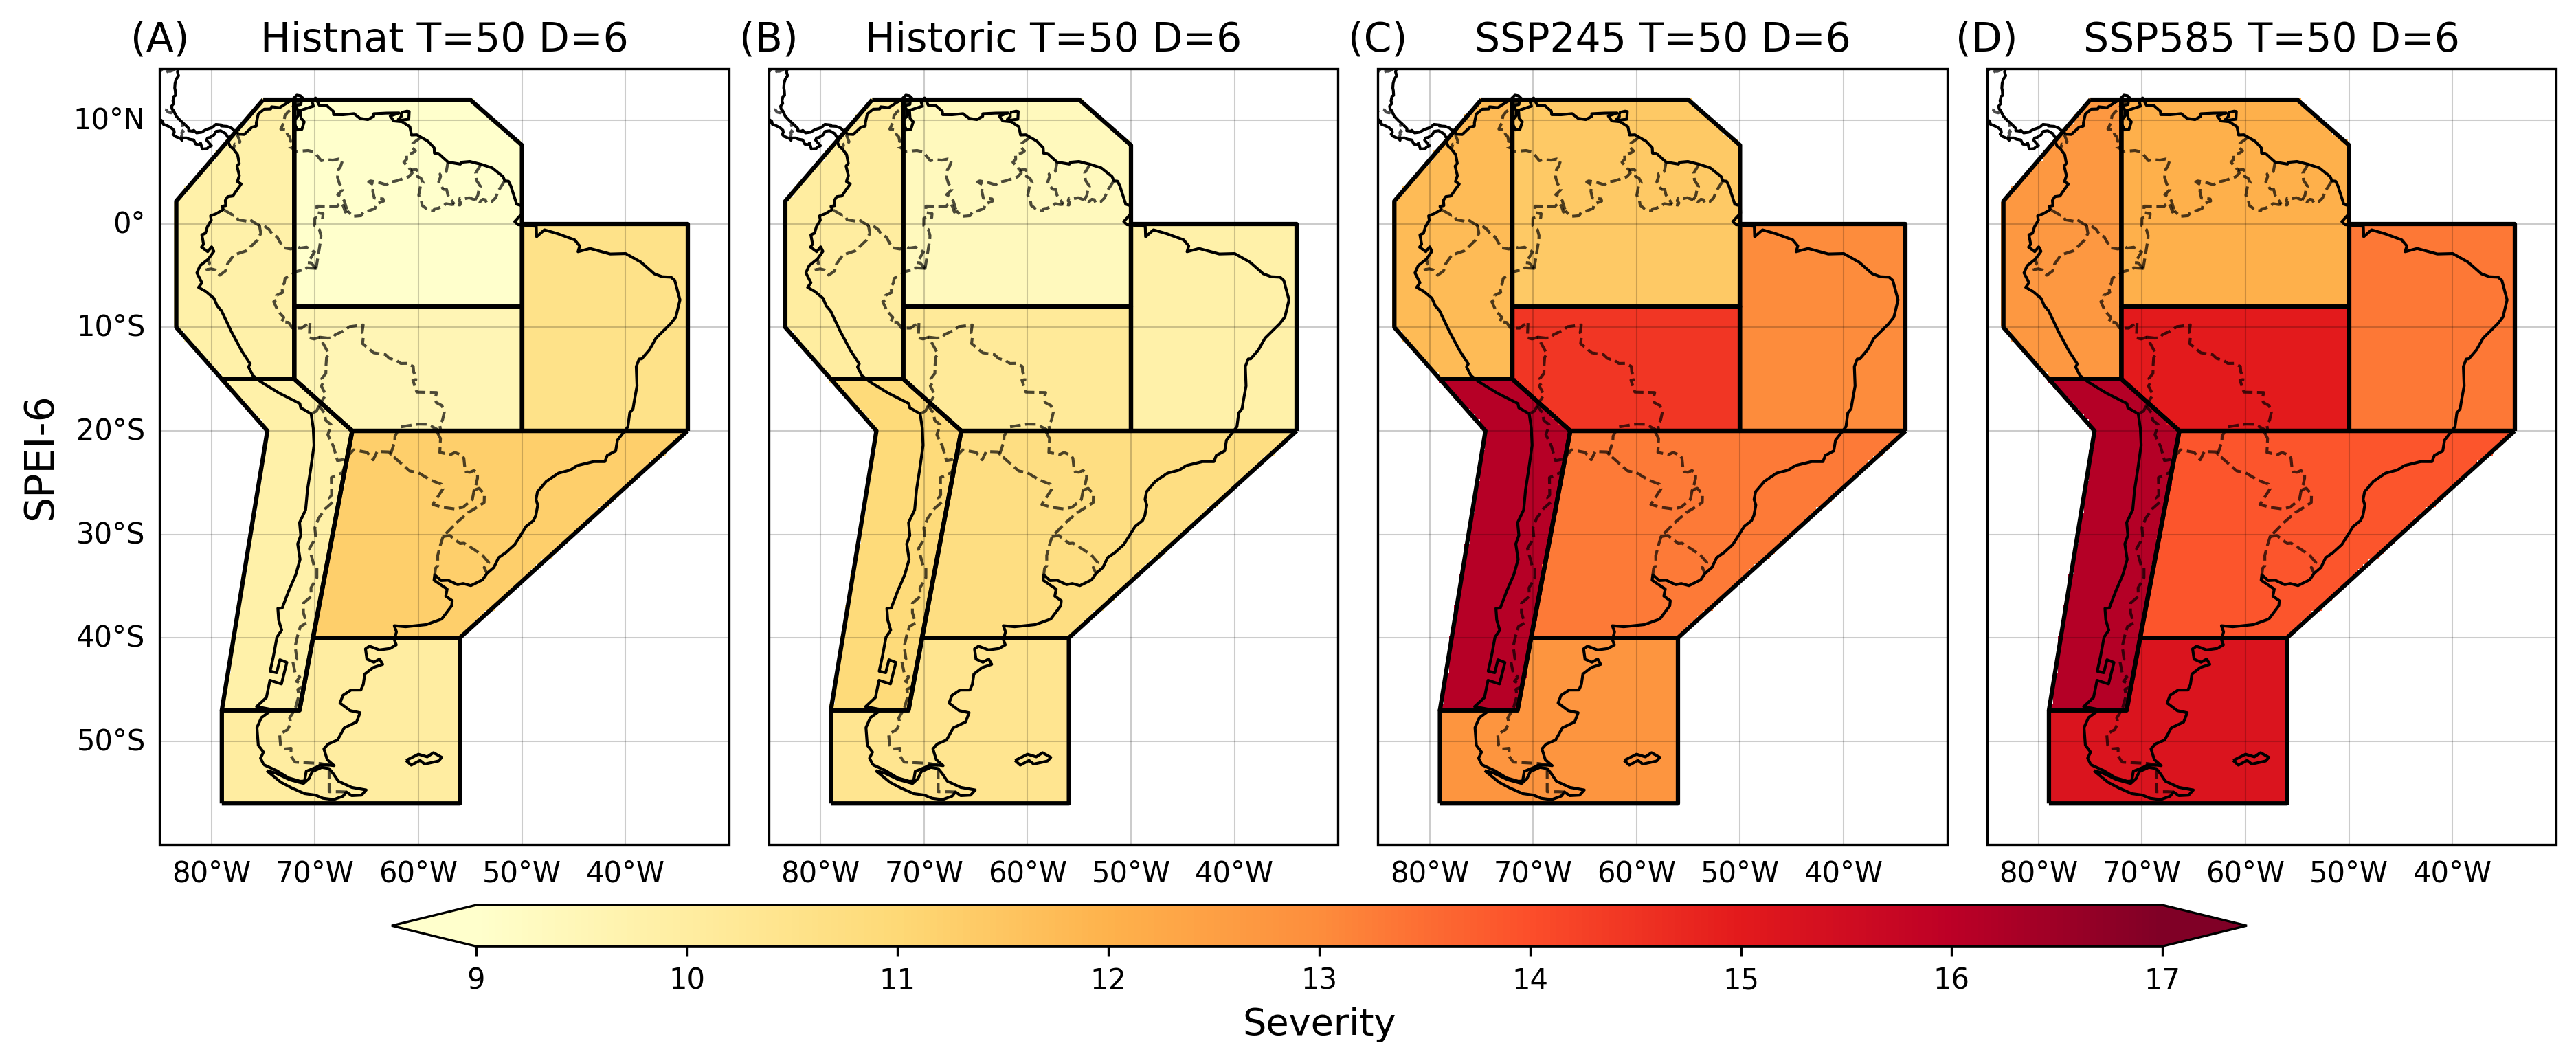

In [17]:
for s in np.arange(0,7):
    sev_DA_nc_histnat_M6 = sev_DA_nc_histnat_M6.where(~region_shp_arr[s], other=M6_df_sev_DA[M6_fn_histnat][s])
    sev_DA_nc_historic_M6 = sev_DA_nc_historic_M6.where(~region_shp_arr[s], other=M6_df_sev_DA[M6_fn_historic][s])
    sev_DA_nc_ssp245_M6 = sev_DA_nc_ssp245_M6.where(~region_shp_arr[s], other=M6_df_sev_DA[M6_fn_ssp245][s])
    sev_DA_nc_ssp585_M6 = sev_DA_nc_ssp585_M6.where(~region_shp_arr[s], other=M6_df_sev_DA[M6_fn_ssp585][s])

fig, ax = plt.subplots(ncols = 4, nrows = 1, figsize = (15,5),sharey="row", dpi = 300, subplot_kw = {"projection" : cartopy.crs.PlateCarree()})
fig.subplots_adjust(wspace=0.07)
elev_kwargs = {"cmap" : "YlOrRd",
               "vmin" : 9, 
               "vmax" : 17}    
cbar=sev_DA_nc_histnat_M6.sev_T100_d1.plot(ax = ax[0], **elev_kwargs, add_colorbar=False)
sev_DA_nc_historic_M6.sev_T100_d1.plot(ax = ax[1], **elev_kwargs, add_colorbar=False)
sev_DA_nc_ssp245_M6.sev_T100_d1.plot(ax = ax[2], **elev_kwargs, add_colorbar=False)
sev_DA_nc_ssp585_M6.sev_T100_d1.plot(ax = ax[3], **elev_kwargs, add_colorbar=False)

fn_names_histnat = "Histnat T=" + T_str + " D=" + M6_D_str
fn_names_historic = "Historic T=" + T_str + " D=" + M6_D_str
fn_names_ssp245 = "SSP245 T=" + T_str + " D=" + M6_D_str
fn_names_ssp585 = "SSP585 T=" + T_str + " D=" + M6_D_str
names = np.array([fn_names_histnat,fn_names_historic,fn_names_ssp245,fn_names_ssp585])

for i in np.arange(0,4):
    ax[i].coastlines()
    ax[i].add_feature(cartopy.feature.BORDERS, lw = 1, alpha = 0.7, ls = "--", zorder = 99)
    ax[i].set_title(names[i], loc = "center",fontsize=14)
    ax[i].set_xlim([-85,-30])
    ax[i].set_ylim([-60,15])
    sf_SA.boundary.plot(ax = ax[i], lw = 1.5, color = "black")
    
glt_1 = ax[0].gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', alpha=0.2, draw_labels=True)
glt_1.top_labels = False
glt_1.right_labels = False
ax[0].text(-0.21, 0.5, 'SPEI-6', transform=ax[0].transAxes, fontsize=14, va='center', ha='center', rotation=90)
for j in np.arange(1,4):
    glt_2 = ax[j].gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', alpha=0.2, draw_labels=True)
    glt_2.top_labels = False
    glt_2.right_labels = False
    glt_2.left_labels = False


cbar_ax = fig.add_axes([0.2, 0.02, 0.6, 0.04])        
cbar = plt.colorbar(cbar, cax=cbar_ax, location = "bottom", fraction = 0.03, pad = 0.09, extend = "both")
cbar.set_label(label = "Severity",fontsize=13)

# Add subplot labels
labels = ['(A)', '(B)', '(C)', '(D)']
for i, axes in enumerate(ax.flat):
    axes.annotate(labels[i], xy=(0, 1.037), xycoords='axes fraction',
                  fontsize=14, ha='center', va='center')

### M12

In [18]:
#Based on the Model Evaluation
M12_region_9_models=[None,None,2,3,4,5,6,7]
M12_region_10_models=[None,1,None,None,4,5,6,7]
M12_region_11_models=[0,1,None,None,None,5,6,7]
M12_region_12_models=[0,1,2,3,4,5,6,None]
M12_region_13_models=[0,1,2,3,None,5,6,7]
M12_region_14_models=[None,None,2,3,None,5,6,7]
#M12_region_15_models=[0,1,2,3,4,5,6,7]
M12_region_15_models=[0,1,2,None,None,5,None,7]
M12_region_models=[M12_region_9_models,M12_region_10_models,M12_region_11_models,M12_region_12_models,M12_region_13_models,M12_region_14_models,M12_region_15_models]

In [19]:
M12_res_histnat_arr = []
M12_res_historic_arr = []
M12_res_ssp245_arr = []
M12_res_ssp585_arr = []
for s in np.arange(0,7,1):    
    region_eval = M12_region_models[s]
    #print(region_eval)
    M12_val_histnat_arr = []
    M12_val_historic_arr = []
    M12_val_ssp245_arr = []
    M12_val_ssp585_arr = []
    
    fn_return_T = "sev_M12_T" + T_str
    for m in np.arange(0,8):
        if region_eval[m] is not None:
            M12_fn_histnat = fn_return_T + "_D" + M12_D_str + "_histnat"
            M12_val_histnat_arr.append(model_M12[m][M12_fn_histnat][s])
            M12_fn_historic = fn_return_T + "_D" + M12_D_str + "_historic"
            M12_val_historic_arr.append(model_M12[m][M12_fn_historic][s])
            M12_fn_ssp245 = fn_return_T + "_D" + M12_D_str + "_ssp245"
            M12_val_ssp245_arr.append(model_M12[m][M12_fn_ssp245][s])
            M12_fn_ssp585 = fn_return_T + "_D" + M12_D_str + "_ssp585"
            M12_val_ssp585_arr.append(model_M12[m][M12_fn_ssp585][s])

    #print(len(M1_val_histnat_arr))
    M12_res_histnat_arr.append(np.array(M12_val_histnat_arr).mean())
    M12_res_historic_arr.append(np.array(M12_val_historic_arr).mean())
    M12_res_ssp245_arr.append(np.array(M12_val_ssp245_arr).mean())
    M12_res_ssp585_arr.append(np.array(M12_val_ssp585_arr).mean())

M12_data_sev_DA = {
    'Region': ['9_NWS','10_NSA','11_NES','12_SAM','13_SWS','14_SES','15_SSA'],
    M12_fn_histnat: M12_res_histnat_arr,
    M12_fn_historic: M12_res_historic_arr,
    M12_fn_ssp245: M12_res_ssp245_arr,
    M12_fn_ssp585: M12_res_ssp585_arr,
}
  
M12_df_sev_DA = pd.DataFrame(M12_data_sev_DA)
display(M12_df_sev_DA) 

,Region,sev_M12_T50_D12_histnat,sev_M12_T50_D12_historic,sev_M12_T50_D12_ssp245,sev_M12_T50_D12_ssp585
0,9_NWS,17.488820,18.524180,20.415897,20.483571
1,10_NSA,16.760896,18.147530,19.466582,19.999411
2,11_NES,19.306287,18.306299,21.238484,21.496703
3,12_SAM,16.246441,19.763186,23.633054,22.989374
4,13_SWS,17.806013,19.431898,24.797733,24.593975
5,14_SES,21.371259,20.185233,23.960145,24.932565
6,15_SSA,17.816290,18.504638,22.517814,23.669218


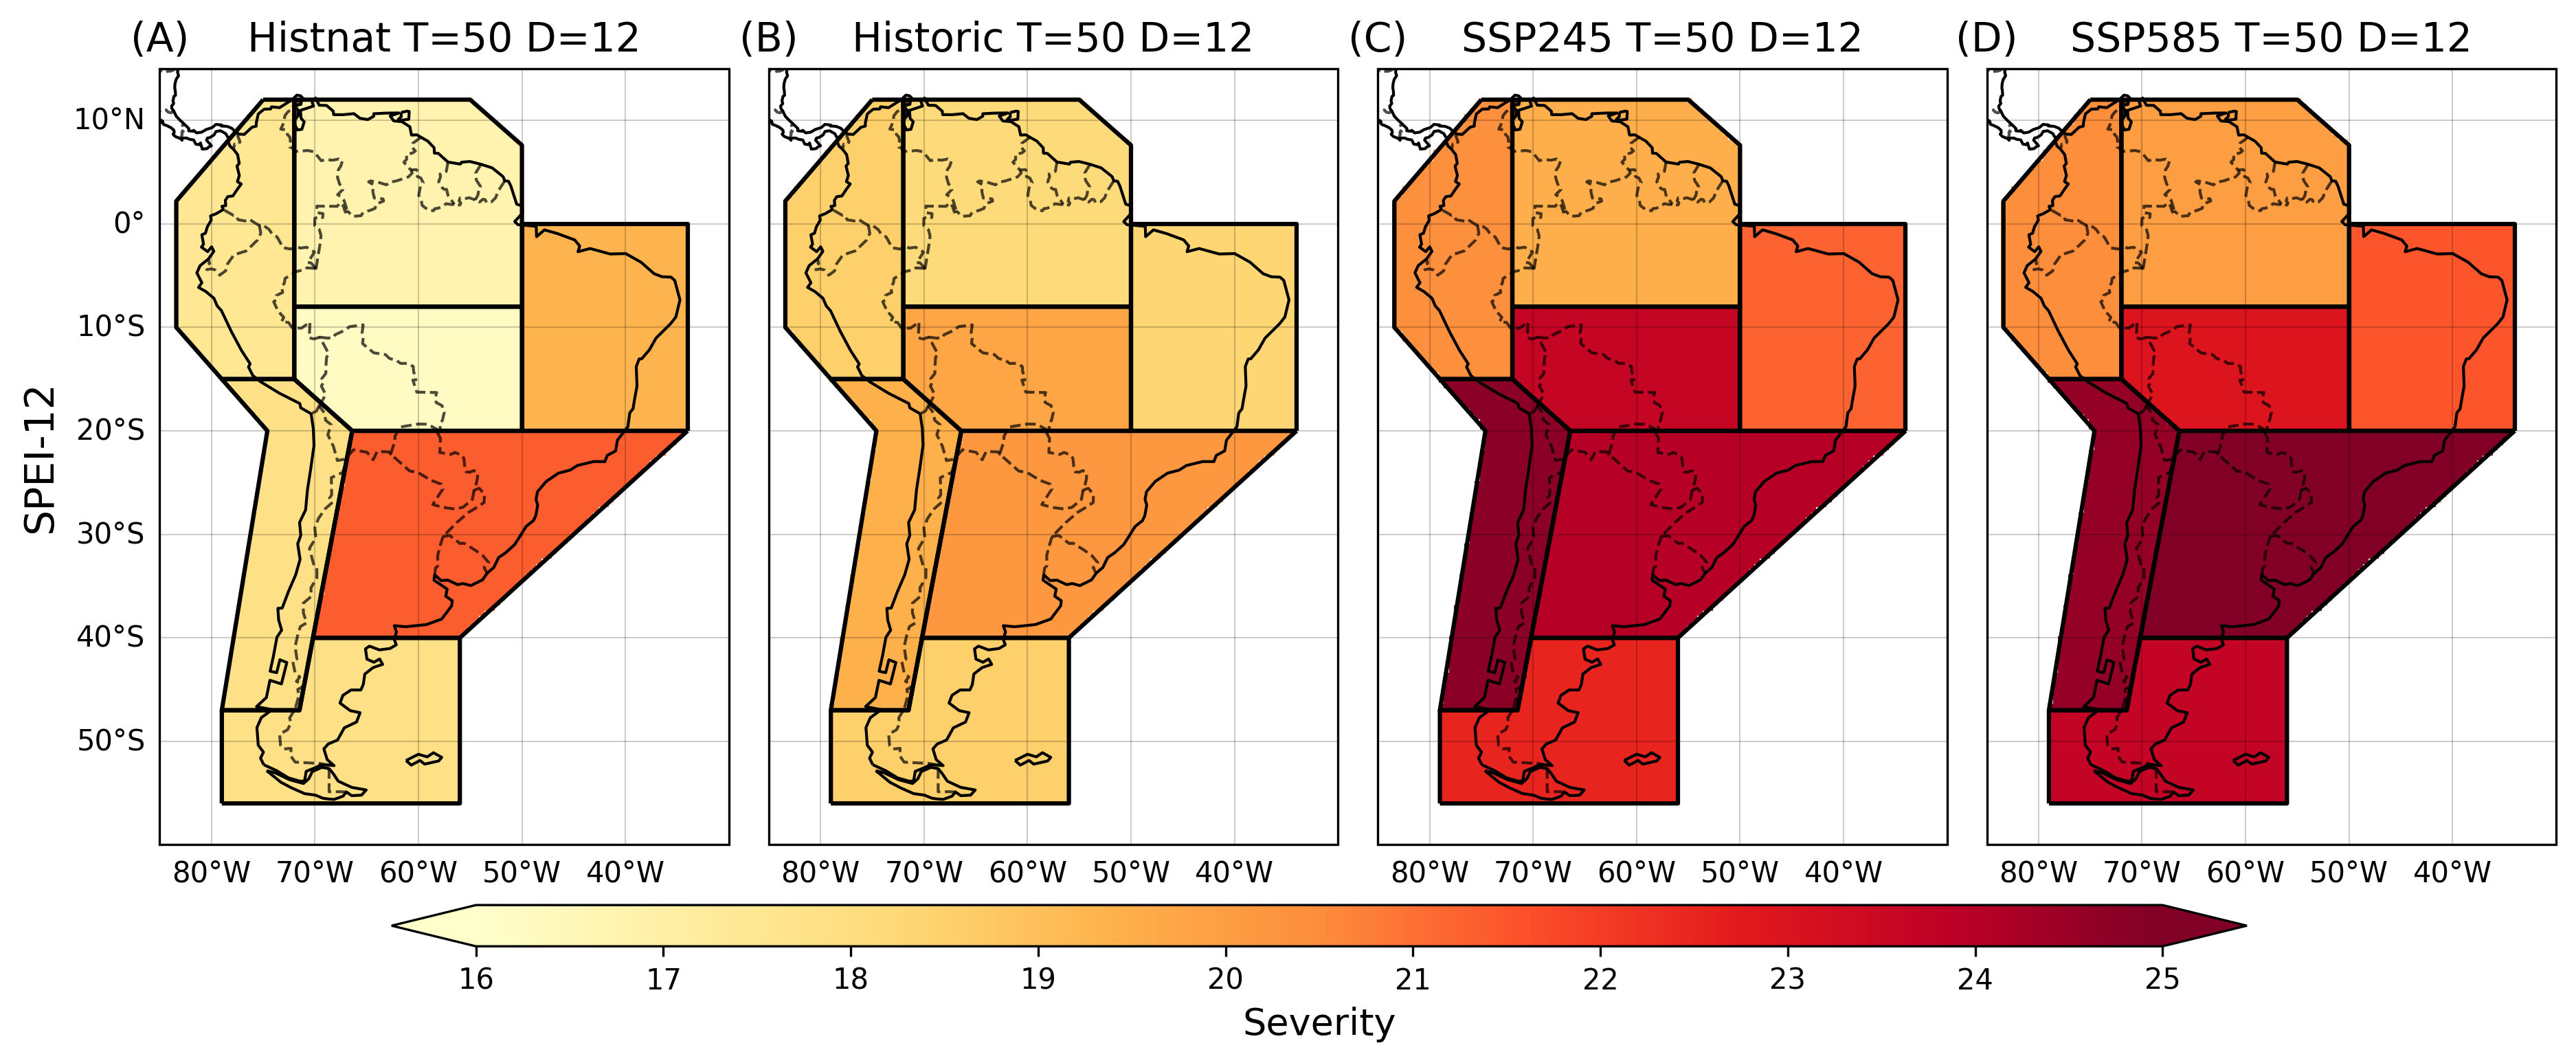

In [20]:
for s in np.arange(0,7):
    sev_DA_nc_histnat_M12 = sev_DA_nc_histnat_M12.where(~region_shp_arr[s], other=M12_df_sev_DA[M12_fn_histnat][s])
    sev_DA_nc_historic_M12 = sev_DA_nc_historic_M12.where(~region_shp_arr[s], other=M12_df_sev_DA[M12_fn_historic][s])
    sev_DA_nc_ssp245_M12 = sev_DA_nc_ssp245_M12.where(~region_shp_arr[s], other=M12_df_sev_DA[M12_fn_ssp245][s])
    sev_DA_nc_ssp585_M12 = sev_DA_nc_ssp585_M12.where(~region_shp_arr[s], other=M12_df_sev_DA[M12_fn_ssp585][s])

fig, ax = plt.subplots(ncols = 4, nrows = 1, figsize = (15,5),sharey="row", dpi = 300, subplot_kw = {"projection" : cartopy.crs.PlateCarree()})
fig.subplots_adjust(wspace=0.07)
elev_kwargs = {"cmap" : "YlOrRd",
               "vmin" : 16, 
               "vmax" : 25}    
cbar=sev_DA_nc_histnat_M12.sev_T100_d1.plot(ax = ax[0], **elev_kwargs, add_colorbar=False)
sev_DA_nc_historic_M12.sev_T100_d1.plot(ax = ax[1], **elev_kwargs, add_colorbar=False)
sev_DA_nc_ssp245_M12.sev_T100_d1.plot(ax = ax[2], **elev_kwargs, add_colorbar=False)
sev_DA_nc_ssp585_M12.sev_T100_d1.plot(ax = ax[3], **elev_kwargs, add_colorbar=False)

fn_names_histnat = "Histnat T=" + T_str + " D=" + M12_D_str
fn_names_historic = "Historic T=" + T_str + " D=" + M12_D_str
fn_names_ssp245 = "SSP245 T=" + T_str + " D=" + M12_D_str
fn_names_ssp585 = "SSP585 T=" + T_str + " D=" + M12_D_str
names = np.array([fn_names_histnat,fn_names_historic,fn_names_ssp245,fn_names_ssp585])

for i in np.arange(0,4):
    ax[i].coastlines()
    ax[i].add_feature(cartopy.feature.BORDERS, lw = 1, alpha = 0.7, ls = "--", zorder = 99)
    ax[i].set_title(names[i], loc = "center",fontsize=14)
    ax[i].set_xlim([-85,-30])
    ax[i].set_ylim([-60,15])
    sf_SA.boundary.plot(ax = ax[i], lw = 1.5, color = "black")
    
glt_1 = ax[0].gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', alpha=0.2, draw_labels=True)
glt_1.top_labels = False
glt_1.right_labels = False
ax[0].text(-0.21, 0.5, 'SPEI-12', transform=ax[0].transAxes, fontsize=14, va='center', ha='center', rotation=90)
for j in np.arange(1,4):
    glt_2 = ax[j].gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', alpha=0.2, draw_labels=True)
    glt_2.top_labels = False
    glt_2.right_labels = False
    glt_2.left_labels = False


cbar_ax = fig.add_axes([0.2, 0.02, 0.6, 0.04])        
cbar = plt.colorbar(cbar, cax=cbar_ax, location = "bottom", fraction = 0.03, pad = 0.09, extend = "both")
cbar.set_label(label = "Severity",fontsize=13)

# Add subplot labels
labels = ['(A)', '(B)', '(C)', '(D)']
for i, axes in enumerate(ax.flat):
    axes.annotate(labels[i], xy=(0, 1.037), xycoords='axes fraction',
                  fontsize=14, ha='center', va='center')